In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import warnings
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

In [3]:
movies_processing = pd.read_csv('../프로젝트csv/movies.csv')

In [4]:
movies_processing['관객수_등급'] = pd.qcut(
    movies_processing['관람객수'], 
    q= 3, 
    labels=range(1, 4)  # 구간을 숫자로 변환 3단계
)
print(movies_processing[['관객수_등급','관람객수']])

     관객수_등급      관람객수
0         3  875001.0
1         3  206309.0
2         3  155562.0
3         3   42290.0
4         3   38131.0
...     ...       ...
6019      2     676.0
6020      2     674.0
6021      2     652.0
6022      2     609.0
6023      2     582.0

[6024 rows x 2 columns]


In [5]:
# 관객수_순위 타입변환
movies_processing['관객수_등급'] = movies_processing['관객수_등급'].astype(int)
print(movies_processing[['관객수_등급','관람객수']].sample(5))

      관객수_등급          관람객수
969        3  21471.933594
2456       3  40219.929688
1742       3  90301.867188
575        2   3259.000000
108        1     21.000000


In [6]:
# 월_계절 컬럼 만들기
def movie_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

In [7]:
movies_processing['개봉월'] = pd.to_numeric(movies_processing['개봉월'], errors='coerce')
movies_processing['계절'] = movies_processing['개봉월'].apply(movie_season)
movies_processing['계절']

0       4
1       4
2       4
3       4
4       4
       ..
6019    3
6020    2
6021    3
6022    3
6023    2
Name: 계절, Length: 6024, dtype: int64

In [8]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_processing['장르'].unique())}
# movies_genre
movies_processing['장르2'] = movies_processing['장르'].map(movies_genre)
print(movies_processing[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [9]:
# 라벨인코딩 
le = LabelEncoder()
movies_processing['등급_le'] = le.fit_transform(movies_processing['등급'])
movies_processing['계절_le'] = le.fit_transform(movies_processing['계절'])

# 데이터 준비 
x = movies_processing[['장르2', '계절_le','총스크린수', '등급_le']]
y = movies_processing['관객수_등급']
# y 원핫인코딩
y = to_categorical(y) # y 원핫인코딩

In [10]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4819, 4), (4819, 4), (1205, 4), (1205, 4))

In [11]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)),  # 입력
    Dense(128, activation=
          'relu'),# 은닉층
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax') # 출력층
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 4)                 2

In [13]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # 원-핫 인코딩된 y_train 사용 시
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)
# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_aud3-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          # 저장경로
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               # 저장 여부 로그 출력 (0:출력 안 함)

hist = model.fit(X_train, y_train, 
                 epochs=500, 
                 validation_split=0.2, 
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/500
121/121 [==============================] - 2s 5ms/step - loss: 1.0824 - accuracy: 0.4350 - val_loss: 1.0209 - val_accuracy: 0.4741
Epoch 2/500
121/121 [==============================] - 1s 4ms/step - loss: 1.0237 - accuracy: 0.4747 - val_loss: 0.9947 - val_accuracy: 0.4917
Epoch 3/500
121/121 [==============================] - 0s 4ms/step - loss: 1.0143 - accuracy: 0.4809 - val_loss: 0.9843 - val_accuracy: 0.5010
Epoch 4/500
121/121 [==============================] - 0s 4ms/step - loss: 1.0077 - accuracy: 0.4903 - val_loss: 0.9816 - val_accuracy: 0.5228
Epoch 5/500
121/121 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.5019 - val_loss: 0.9624 - val_accuracy: 0.5228
Epoch 6/500
121/121 [==============================] - 0s 4ms/step - loss: 0.9850 - accuracy: 0.5082 - val_loss: 0.9709 - val_accuracy: 0.5052
Epoch 7/500
121/121 [==============================] - 0s 4ms/step - loss: 0.9794 - accuracy: 0.5193 - val_loss: 0.9651 - val_accuracy: 0.4990

Epoch 58/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8918 - accuracy: 0.5735 - val_loss: 0.9274 - val_accuracy: 0.5508
Epoch 59/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8862 - accuracy: 0.5715 - val_loss: 0.9361 - val_accuracy: 0.5456
Epoch 60/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8835 - accuracy: 0.5798 - val_loss: 0.9331 - val_accuracy: 0.5488
Epoch 61/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8885 - accuracy: 0.5751 - val_loss: 0.9307 - val_accuracy: 0.5674
Epoch 62/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8846 - accuracy: 0.5759 - val_loss: 0.9346 - val_accuracy: 0.5415
Epoch 63/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8847 - accuracy: 0.5782 - val_loss: 0.9264 - val_accuracy: 0.5446
Epoch 64/500
121/121 [==============================] - 0s 4ms/step - loss: 0.8831 - accuracy: 0.5754 - val_loss: 0.9299 - val_accuracy:

Epoch 115/500
121/121 [==============================] - 1s 4ms/step - loss: 0.8543 - accuracy: 0.5917 - val_loss: 0.9318 - val_accuracy: 0.5737
Epoch 116/500
121/121 [==============================] - 1s 4ms/step - loss: 0.8412 - accuracy: 0.5956 - val_loss: 0.9424 - val_accuracy: 0.5664
Epoch 117/500
121/121 [==============================] - 1s 5ms/step - loss: 0.8383 - accuracy: 0.6044 - val_loss: 0.9384 - val_accuracy: 0.5778
Epoch 118/500
121/121 [==============================] - 1s 5ms/step - loss: 0.8329 - accuracy: 0.6000 - val_loss: 0.9554 - val_accuracy: 0.5768
Epoch 119/500
121/121 [==============================] - 1s 5ms/step - loss: 0.8445 - accuracy: 0.5951 - val_loss: 0.9515 - val_accuracy: 0.5674
Epoch 120/500
121/121 [==============================] - 1s 5ms/step - loss: 0.8422 - accuracy: 0.5933 - val_loss: 0.9500 - val_accuracy: 0.5726
Epoch 121/500
121/121 [==============================] - 1s 4ms/step - loss: 0.8411 - accuracy: 0.5995 - val_loss: 0.9481 - val_ac

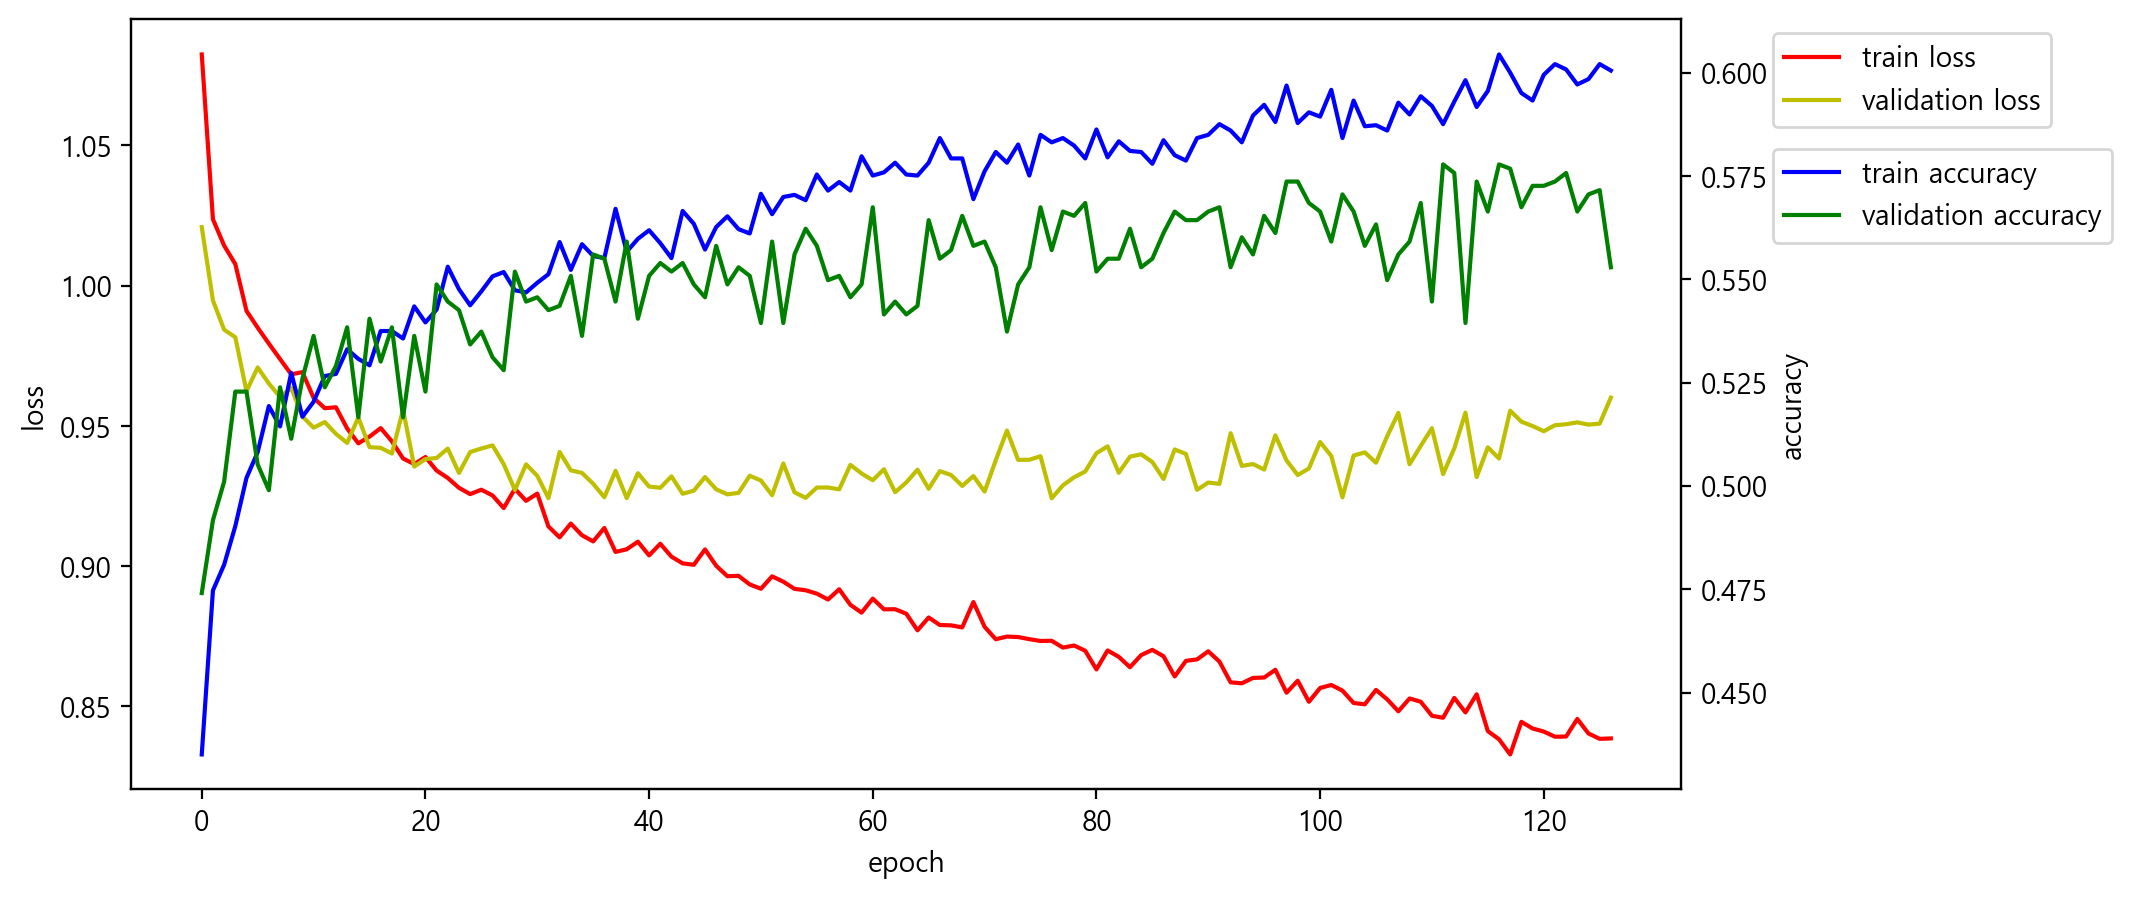

In [14]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10, 5))

# Loss 그래프
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

# Accuracy 그래프 (y축 공유)
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')

# 범례(legend) 위치 조정 - 바깥으로 이동
loss_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # loss legend
acc_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85))  # accuracy legend

# 그래프 표시
plt.show()

In [15]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.5485
accuracy : 54.85 %


In [16]:
# 모델 평가 
# f1스코어
y_hat = model.predict(X_test).argmax(axis=1)
y_test = np.argmax(y_test, axis=1)
print(confusion_matrix(y_test, y_hat))
print('f1 score:', f1_score(y_test, y_hat, average='macro'))
# 크로스탭 
crosstab_result = pd.crosstab(y_test, # 실제값(1차원) 
            y_hat.reshape(-1), # 예측값(1차원)    
            rownames=['실제값'],
            colnames=['예측값']
           )

group_labels = ["낮은 관객 수 그룹",  "중간 그룹",  "높은 관객 수 그룹"]

# 행과 열의 인덱스 이름 변경
crosstab_result.index = group_labels
crosstab_result.columns = group_labels

crosstab_result

38/38 [==============================] - 0s 2ms/step
[[167 106  98]
 [ 83 209 135]
 [ 24  98 285]]
f1 score: 0.5438882403998683


,낮은 관객 수 그룹,중간 그룹,높은 관객 수 그룹
낮은 관객 수 그룹,167,106,98
중간 그룹,83,209,135
높은 관객 수 그룹,24,98,285


# 5등급

In [17]:
movies_processing['관객수_등급'] = pd.qcut(
    movies_processing['관람객수'], 
    q= 5, 
    labels=range(1, 6)  # 구간을 숫자로 변환 5단계
)
print(movies_processing[['관객수_등급','관람객수']])

     관객수_등급      관람객수
0         5  875001.0
1         5  206309.0
2         5  155562.0
3         5   42290.0
4         5   38131.0
...     ...       ...
6019      3     676.0
6020      3     674.0
6021      3     652.0
6022      3     609.0
6023      3     582.0

[6024 rows x 2 columns]


In [18]:
# 라벨인코딩 
le = LabelEncoder()
movies_processing['등급_le'] = le.fit_transform(movies_processing['등급'])
movies_processing['계절_le'] = le.fit_transform(movies_processing['계절'])

# 데이터 준비 
x = movies_processing[['장르2', '계절_le','총스크린수', '등급_le']]
y = movies_processing['관객수_등급']
# y 원핫인코딩
y = to_categorical(y) # y 원핫인코딩

In [19]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4819, 4), (4819, 6), (1205, 4), (1205, 6))

In [20]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)),  # 입력
    Dense(128, activation=
          'relu'),# 은닉층
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax') # 출력층
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               640       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 6)                

In [22]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # 원-핫 인코딩된 y_train 사용 시
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)
# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_aud3-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          # 저장경로
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               # 저장 여부 로그 출력 (0:출력 안 함)

hist = model.fit(X_train, y_train, 
                 epochs=500, 
                 validation_split=0.2, 
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/500
121/121 [==============================] - 1s 7ms/step - loss: 1.6162 - accuracy: 0.2760 - val_loss: 1.5434 - val_accuracy: 0.3185
Epoch 2/500
121/121 [==============================] - 1s 5ms/step - loss: 1.5305 - accuracy: 0.3082 - val_loss: 1.5059 - val_accuracy: 0.3392
Epoch 3/500
121/121 [==============================] - 1s 5ms/step - loss: 1.5114 - accuracy: 0.3300 - val_loss: 1.4917 - val_accuracy: 0.3465
Epoch 4/500
121/121 [==============================] - 1s 4ms/step - loss: 1.4892 - accuracy: 0.3351 - val_loss: 1.4689 - val_accuracy: 0.3465
Epoch 5/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4833 - accuracy: 0.3512 - val_loss: 1.4627 - val_accuracy: 0.3631
Epoch 6/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4812 - accuracy: 0.3494 - val_loss: 1.4694 - val_accuracy: 0.3610
Epoch 7/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4701 - accuracy: 0.3564 - val_loss: 1.4568 - val_accuracy: 0.3683

Epoch 58/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3022 - accuracy: 0.4514 - val_loss: 1.3929 - val_accuracy: 0.4212
Epoch 59/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3046 - accuracy: 0.4506 - val_loss: 1.4093 - val_accuracy: 0.4118
Epoch 60/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2995 - accuracy: 0.4506 - val_loss: 1.4028 - val_accuracy: 0.3921
Epoch 61/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2998 - accuracy: 0.4464 - val_loss: 1.4103 - val_accuracy: 0.4056
Epoch 62/500
121/121 [==============================] - 0s 4ms/step - loss: 1.3018 - accuracy: 0.4431 - val_loss: 1.3980 - val_accuracy: 0.4087
Epoch 63/500
121/121 [==============================] - 1s 5ms/step - loss: 1.2949 - accuracy: 0.4490 - val_loss: 1.4049 - val_accuracy: 0.3983
Epoch 64/500
121/121 [==============================] - 1s 5ms/step - loss: 1.2981 - accuracy: 0.4433 - val_loss: 1.3970 - val_accuracy:

In [23]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 2ms/step - loss: 1.4263 - accuracy: 0.4149
accuracy : 41.49 %


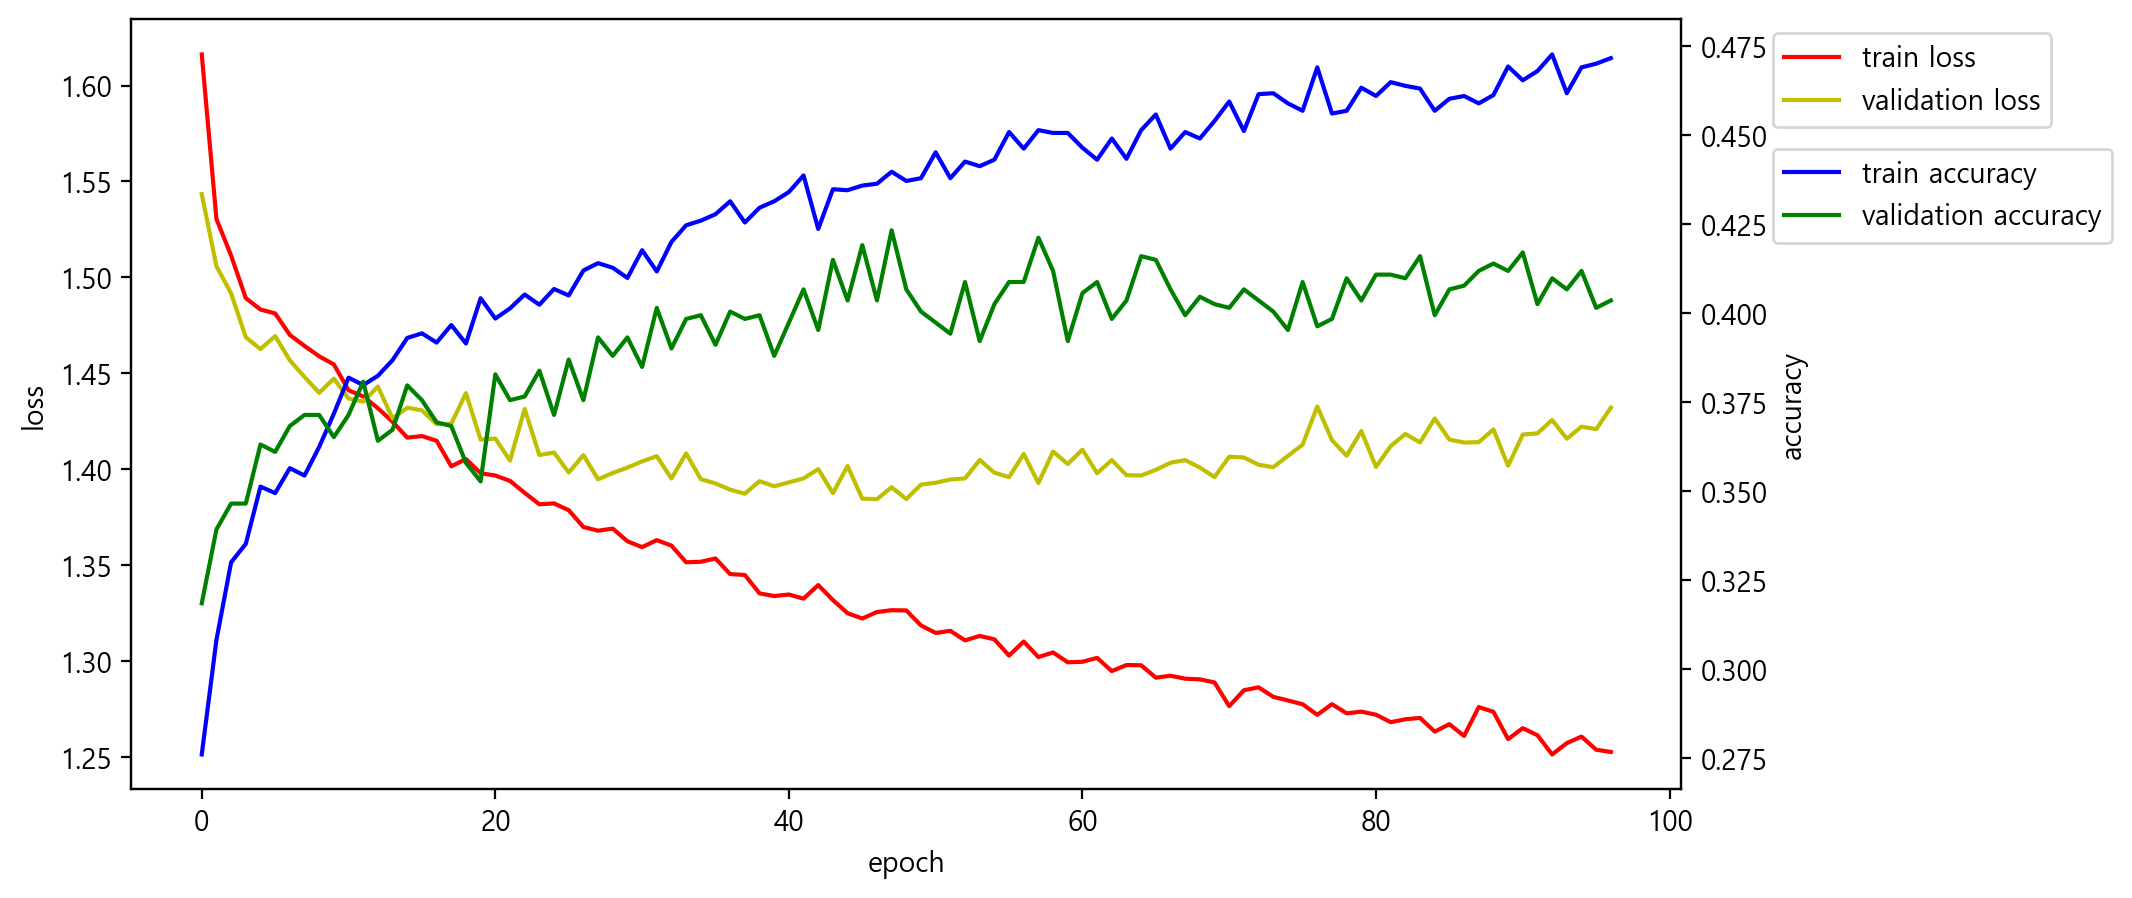

In [24]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10, 5))

# Loss 그래프
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

# Accuracy 그래프 (y축 공유)
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')

# 범례(legend) 위치 조정 - 바깥으로 이동
loss_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # loss legend
acc_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85))  # accuracy legend

# 그래프 표시
plt.show()

In [25]:
# 모델 평가 
# f1스코어
y_hat = model.predict(X_test).argmax(axis=1)
y_test = np.argmax(y_test, axis=1)
print(confusion_matrix(y_test, y_hat))
print('f1 score:', f1_score(y_test, y_hat, average='macro'))
# 크로스탭 
crosstab_result = pd.crosstab(y_test, # 실제값(1차원) 
            y_hat.reshape(-1), # 예측값(1차원)    
            rownames=['실제값'],
            colnames=['예측값']
           )

group_labels = ["낮은 관객 수 그룹", "중간 하위 그룹", "중간 그룹", "중간 상위 그룹", "높은 관객 수 그룹"]

# 행과 열의 인덱스 이름 변경
crosstab_result.index = group_labels
crosstab_result.columns = group_labels

crosstab_result

38/38 [==============================] - 0s 1ms/step
[[ 67  33  49  46  26]
 [ 47  49  54  49  42]
 [ 22  23  85  69  52]
 [  8  16  36 150  62]
 [ 12   9  17  33 149]]
f1 score: 0.3981209151575921


,낮은 관객 수 그룹,중간 하위 그룹,중간 그룹,중간 상위 그룹,높은 관객 수 그룹
낮은 관객 수 그룹,67,33,49,46,26
중간 하위 그룹,47,49,54,49,42
중간 그룹,22,23,85,69,52
중간 상위 그룹,8,16,36,150,62
높은 관객 수 그룹,12,9,17,33,149


In [26]:
movies_processing.to_csv('../프로젝트csv/movies.csv', index=False, encoding='utf-8')